<a href="https://colab.research.google.com/github/nguyenbinh0807/STOCK_INDEX/blob/main/predict_forex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Đào tạo mô hình dự đoán thị trường ngoại hối dựa trên các chỉ báo kĩ thuật

. Thị trường ngoại hối được xem nhữ một thị trường lớn nhất thế giới bởi vì việc trao đổi giữa cá đồng tiền với nhau ảnh hưởng đến việc kinh doanh và hoạt động lâu dài của các công ty trên thế giới.

. Thị trường ngoại hối sẽ cho phép hai đồng tiền được trao đổi lẫn nhau với một tỷ giá có thể giao động theo biên độ ngày.

Nay mình sẽ đào tạo mô hình để dự báo, mình dựa vào 

1)các chỉ báo như moving average, MACD, RSI,... Để làm đầu vào

2)áp dụng thuật toán LSTM để đưa ra kết quả dự báo

Lần này mình sẽ lấy dữ liệu của cặp tiền đô và yên từ ngày 01/01/2017 đến 29/12/2022, dữ liệu được lấy trên thư viện yfinance

1) phần đầu ta sẽ lấy dữ liệu và vẽ giá đóng cửa

2) tạo các chỉ báo làm đầu vào(sma, ema, macd, rsi, bollinger_band, Volume oscillator)

3)chia tách dữ liệu train test

4)tạo model

5)train model

các kết quả sẽ đưa hết vào hàm run_predict() để cho ra kết quả

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import set_random_seed

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler

import tensorflow as tf
import math

In [ ]:
from time import strftime
ticker='usdjpy'
start_date='2017-01-01'
end_date=datetime.now().strftime('%Y-%m-%d')

def load_data(ticker, start_date, end_date):
  data=yf.download(tickers='{}=X'.format(ticker.upper()), start=start_date, end=end_date)
  return data.iloc[:, 0:4]

price_stock=load_data(ticker, start_date, end_date).reset_index()
price_stock.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close
0,2017-01-02,116.809998,117.485001,116.724998,116.794998
1,2017-01-03,117.487999,118.593002,117.286003,117.495003
2,2017-01-04,117.678001,118.176003,117.068001,117.658997
3,2017-01-05,117.056000,117.084999,115.292999,117.112999
4,2017-01-06,115.318001,116.744003,115.263000,115.264999


In [ ]:
def plot_data(data):
  plt.style.use('seaborn')
  fig=plt.figure(figsize=(15,8))
  plt.plot(data.index, data['Close'])
  ax=fig.gca()
  ax.xaxis.set_major_locator(plt.MaxNLocator(15))
  plt.title('Closing Price')
  plt.xlabel('Date')
  plt.ylabel('Price [PIP]')
  plt.tight_layout()
  plt.show()

In [ ]:
from pandas.core import window
from pandas.io.pytables import PossibleDataLossError
#SMA
def sma(data, days=[30,40,50]):
  df_output=pd.DataFrame()
  for index in range(len(days)):
    sma_index=data.rolling(window=days[index]).mean()
    sma_index=sma_index[['Close']]
    sma_index=sma_index.rename(columns={
        'Close': 'Close_SMA_{}'.format(days[index])
    })
    df_output=pd.concat([df_output, sma_index], axis=1)
  return df_output
#EMA
def ema(data, days=[30,40,50]):
  df_output=pd.DataFrame()
  for index in range(len(days)):
    ema_index=pd.Series.ewm(data['Close'], span=days[index]).mean().to_frame()
    ema_index=ema_index.rename(columns={
        'Close': 'Close_EMA_{}'.format(days[index])
    })
    df_output=pd.concat([df_output, ema_index], axis=1)
  return df_output


    # Volume oscillator ( 30, 40, 50 Days) for TBD?
    # Reference: TBD
def aroon(data, days=[30,40,50]):
  df_output=pd.DataFrame()
  for index in range(len(days)):
    up=100*data['High'].rolling(days[index]+1).apply(lambda x: x.argmax())/days[index]
    dn=100*data['Low'].rolling(days[index]+1).apply(lambda x: x.argmin())/days[index]

    arron_osc_index=dn-up
    arron_osc_index=arron_osc_index.to_frame()
    arron_osc_index.columns=['aroon_osc_{}'.format(days[index])]
    df_output=pd.concat([df_output, arron_osc_index], axis=1)
  
  return df_output

    #MACD
def macd(data, n_fast=26, n_slow=12):
  emafast=pd.Series(data['Close'].ewm(span=n_fast, min_periods=n_slow).mean())
  emaslow=pd.Series(data['Close'].ewm(span=n_slow, min_periods=n_slow).mean())
  MACD=pd.Series(emafast-emaslow, name='MACD_'+str(n_fast)+'_'+str(n_slow))
  MACDsign=pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_'+str(n_fast)+'_'+str(n_slow))
  MACDdiff=pd.Series(MACD-MACDsign, name='MACDdiff_'+str(n_fast)+'_'+str(n_slow))
  df_output=MACD.to_frame()
  df_output=pd.concat([df_output, MACDsign, MACDdiff], axis=1)
  
  return df_output
  #RSI
   # Choice of n = 14 is due to Wilder recommended a smoothing period of 14 (see exponential smoothing, i.e. α = 1/14 or N = 14).
def relative_strength_index(data, n=14):
  index=0
  up=[0]
  do=[0]
  data=data.reset_index()
  while index+1<=data.index[-1]:
    upmove=data.loc[index+1, 'High']-data.loc[index, 'High']
    domove=data.loc[index, 'Low']-data.loc[index+1, 'Low']
    if upmove>domove and upmove>0:
      upd=upmove
    else:
      upd=0
    up.append(upd)
    if domove>upmove and domove>0:
      dod=domove
    else:
      dod=0
    do.append(dod)
    index=index+1
  up=pd.Series(up)
  do=pd.Series(do)
  posd=pd.Series(up.ewm(span=n, min_periods=n).mean())
  negd=pd.Series(do.ewm(span=n, min_periods=n).mean())
  df_output=pd.Series(posd/(posd+negd), name='RSI_'+str(n)).to_frame()
  return df_output
  #bollinger bands
def bollinger_bands(data, days=[30,40,50]):
  df_output=pd.DataFrame()
  for index in range(len(days)):
    MA=pd.Series(data['Close'].rolling(window=days[index], min_periods=days[index]).mean())
    MSD=pd.Series(data['Close'].rolling(window=days[index], min_periods=days[index]).std())
    b1=4*MSD/MA
    upper=pd.Series(b1, name='Bollingerupper_'+str(days[index]))
    data.join(upper)
    b2=(data['Close']-MA+2*MSD)/(4*MSD)
    lower=pd.Series(b2, name='Bollingerlower_'+str(days[index]))
    df_output=pd.concat([df_output, lower], axis=1)
  return df_output

In [ ]:
def feature_engineering(data):
  #sma
  data_sma=sma(data)
  #ema
  data_ema=ema(data)
  #aroon
  data_aroon=aroon(data)
  #macd
  data_macd=macd(data)
  #rsi
  data_rsi=relative_strength_index(data)
  #bollinger bands
  data_bollinger=bollinger_bands(data)
  #stochastic_oscillator_d
  #stochastic_oscillator_k
  #stochastic_momentum_ind
  #chande_momentum_oscillator
  #commodity_channel_index
  #Chaikin
  #Chaikin_osc
  #trend_detection_index
  #rate_of_price_change
  #william
  
  for feature in [data_sma, data_ema, data_aroon, data_macd, data_rsi, data_bollinger]:
    data=pd.concat([data, feature], axis=1)
  data=data.set_index('Date')
  return data

In [ ]:
def timeseries_engineering(data, target_variable, lookahead, lookbacks, dropna=False):
  #predict target_variable
  data_y=data[target_variable].to_frame()
  #ta can tach x va y ra
  if lookahead==0:
    data=data.drop(target_variable, axis=1)
  data_postamle=data.add_suffix('_t')
  data_postamle=pd.concat([
      data_postamle, pd.DataFrame(np.zeros_like(data), index=data.index, 
          columns=data.columns).add_suffix('_d')
  ], axis=1)
  data_shifted=pd.DataFrame()
  for index in range(lookbacks, 0, -1):
    data_shifted_index=data.shift(1).add_suffix('_t-{}'.format(index))#dich chuyen chi muc
    data_diff_index=data.diff(index).add_suffix('_d-{}'.format(index))#so sanh gia cac ngay truoc do
    
    data_shifted=pd.concat([data_shifted, data_shifted_index, data_diff_index], axis=1)
  data_y_shifted=data_y.shift(-lookahead).add_suffix('_t+{}'.format(lookahead))
  data_output=pd.concat([data_shifted, data_postamle, data_y_shifted], axis=1)
  if dropna:
    data_output.dropna(inplace=True)
  else:
    #fill thanh gia tri cuoi
    data_output.fillna(method='bfill', inplace=True)
    #fill gia tri dau
    data_output.fillna(method='ffill', inplace=True)
    data_output.dropna(how='any', axis=1, inplace=True)
  assert(data_output.isnull().sum().sum()==0)
  engineered_target_variable = f'{target_variable}_t+{lookahead}'#day la bien ta can du doan gia close 30 ngay sau
  
  return data_output, engineered_target_variable

In [ ]:
def train_test_split_time(data, label, time_steps, train_size, rebalance=False):
  data_y=data[label]
  data_x=data.drop(label, axis=1)
  
  if rebalance:
    try:
      print('neu mau qua muc ta can bang phuong thuc randomoversample')
      ros=RandomOverSampler(random_state=0)
      data_x, data_y=ros.fit_resample(data_x, data_y)
    except Exception as e:
      print(f'WARNING: lay mau bang phuong thuc khong thanh co do {e}.')
      raise ValueError()
    else:
      print('du lieu time series se bi loi')

  m=int(data_x.shape[0]/time_steps*train_size)
  train_rows=int(m*time_steps)

  test_offset=((data_x.shape[0]-train_rows)//time_steps)*time_steps
  x_train=data_x.iloc[:train_rows, :]
  x_test=data_x.iloc[train_rows:(train_rows+test_offset), :]
  y_train=data_y[:train_rows]
  y_test=data_y[train_rows:(train_rows+test_offset)]
    
  return x_train, x_test, y_train, y_test, x_test.index


In [ ]:
def rmse(y_true, y_pred):
  return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true), axis=-1))

In [ ]:
def create_lstm_nn(input_shape, output_shape, depth=8, width=16):
  mX, nX = input_shape
        
  model = keras.Sequential()
  model.add(layers.LSTM(input_shape=(mX, nX), recurrent_dropout=0.8,
                              units=width, return_sequences=False, 
                              activation="relu",
                              recurrent_activation="sigmoid"))

  for hidden in np.arange(depth):
    model.add(layers.Dense(width, activation='relu'))
        
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(1, activation='linear'))
        
        
    
        
  model.compile(loss=rmse, optimizer='adam', metrics=['mse'])
        
  # Reporting the number of parameters
  print(model.summary())
    
  num_params = model.count_params()
  print('Number of parameters: {}'.format(num_params))
        
  return model

In [ ]:
def train_model(X_train, X_test, y_train, y_test, lookbacks, epoch_count, batch_size, callback=None, verbose=True):
        # Store number of learning features
  mX, nX = X_train.shape
        
        # Scale X features
  sc = MinMaxScaler()
  X_train = sc.fit_transform(X_train)
  X_test = sc.transform(X_test)

        # Now, reshape input to be 3-D: [timesteps, batch, feature]
  X_train = np.reshape(X_train, (-1, lookbacks + 1, X_train.shape[1] // (lookbacks + 1)))
  X_test = np.reshape(X_test, (-1, lookbacks + 1, X_test.shape[1] // (lookbacks + 1)))

    
  print('INFORMATION: Starting optimization...')
        
  model = create_lstm_nn(input_shape=(X_train.shape[1], X_train.shape[2]),
                                      output_shape=(X_train.shape[1], 1))
        
        #patience = 2 * lookbacks
  callback_list = [] # EarlyStopping(monitor='val_loss', min_delta=0, patience=patience)]
        
  if callback is not None:
    callback_list = callback_list + [callback]
            
  history = model.fit(X_train, y_train, epochs=epoch_count, batch_size=batch_size, 
                      callbacks=callback_list,
                      validation_data=(X_test, y_test), 
                      #validation_split=0.5, # cannot do this for time series due to randomness
                      verbose=verbose, shuffle=True)
        
  y_pred_test = model.predict(X_test, batch_size=batch_size) 
            
  return history, model, y_pred_test

In [ ]:
def plot_learning_history(history, title):
  fig=plt.figure(figsize=(8,5))

  plt.rcParams['font.family']='Arial'
  plt.rcParams['font.size']='14'

  plot1, = plt.plot(history.epoch, history.history['loss'], c='blue')
  plot2, = plt.plot(history.epoch, history.history['val_loss'], linestyle='--', c='blue')
  plt.grid(which='both', linestyle='--')
        
  ax = fig.gca()    
  ax_sec = ax.twinx()
  plot3, = ax_sec.plot(history.epoch, history.history['mse'], lw=2, c='red')
  plot4, = ax_sec.plot(history.epoch, history.history['val_mse'], linestyle='--', lw=2, c='red')
        
  ax.set_xlabel(r'Epoch')
  ax.set_ylabel(r'Loss')
  ax_sec.set_ylabel(r'MSE')
  plt.legend([plot1, plot2, plot3, plot4], [r'Training Loss', r'Validation Loss', r'Training MSE', r'Validation MSE'],
                    bbox_to_anchor=(-0.1, -0.02, 1.20, 1), bbox_transform=fig.transFigure, 
                    loc='lower center', ncol=4, mode="expand", borderaxespad=0.)
        
  plt.title(title)
  plt.show()

In [ ]:
def plot_prices(X_test, y_test, y_pred_nn, lookahead):
  fig = plt.figure(figsize=(15,8))
  plot_actual, = plt.plot(X_test.index, X_test['Close_t'], linewidth=2.75, label='True test data')
  plot_test, = plt.plot(y_test, label=f'True lookforward-{lookahead} test data') 
  plot_predicted, = plt.plot(y_test.index, y_pred_nn, label=f'Predicted lookforward-{lookahead} data') 
  plt.legend()
  
  ax = fig.gca()
  ax.xaxis.set_major_locator(plt.MaxNLocator(10)) # Too many dates.
  plt.grid(True)
  plt.title('Closing Price')
  plt.xlabel('Date')
  plt.ylabel('Price [USD]')
  fig.show()

In [ ]:
def run_prediction(data, target_variable, train_size, lookahead, lookbacks, epoch_count, batch_size):
  """
  run_prediction(params):
  INPUT:
  -target_variable: la cot can du doan
  -train_size: la tap train chiem bao nhieu trong du lieu
  -lookahead: so ngay ta can du doan
  """
  #create feature
  if data.shape[0]==0:
    return None
  data_feature=feature_engineering(data)#ok

  #plot data close
  print(plot_data(data_feature))#ok
  
  #predict 30 days
  data_eng, engineerd_label=timeseries_engineering(data_feature, target_variable, lookahead, lookbacks, dropna=False)#ok
  #print(data_eng)
  #split train and test
  x_train, x_test, y_train, y_test, index_x_test= train_test_split_time(
    data_eng, engineerd_label, 1, train_size)#ok
  
  #train model
  history, model, y_pred_nn=train_model(x_train, x_test, y_train, y_test, lookbacks, epoch_count, batch_size)#ok
  
  #plot y_test, y_pred
  print(plot_learning_history(history, title=f'For Stock + {lookahead} using {lookbacks} lookbacks'))
  #predict nexts 30 days
  print(plot_prices(x_test, y_test, y_pred_nn, lookahead))

  y_last_date=y_pred_nn[-1][0]
  y_first_date=data['Close'].iloc[-1]
  #return next 30days
  generate_return= (y_last_date-y_first_date)/y_first_date*100

  print('For ticker {0}, the forecasted return is {1:3f}%'.format('Close', generate_return))

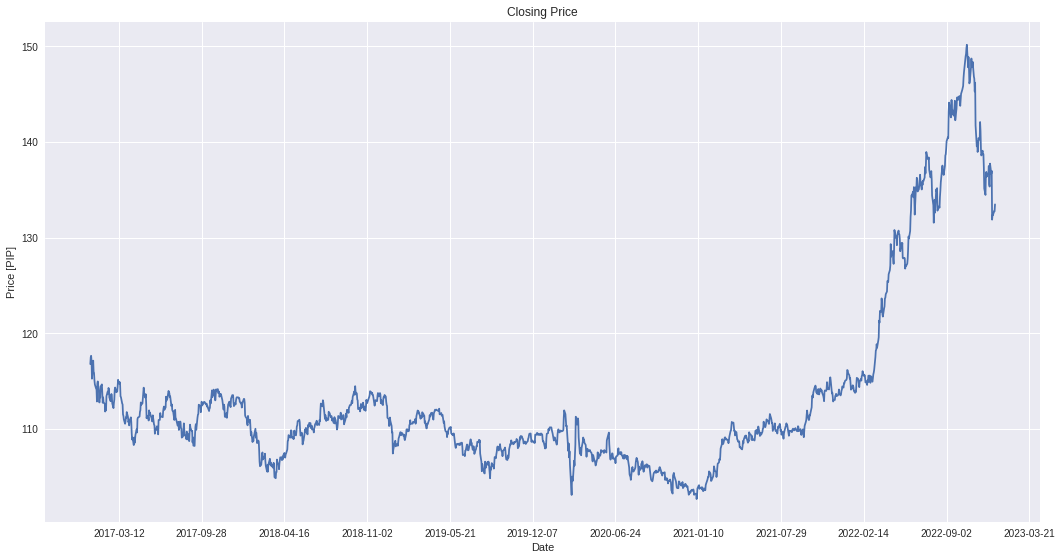

None
INFORMATION: Starting optimization...
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 16)                3648      
                                                                 
 dense_225 (Dense)           (None, 16)                272       
                                                                 
 dense_226 (Dense)           (None, 16)                272       
                                                                 
 dense_227 (Dense)           (None, 16)                272       
                                                                 
 dense_228 (Dense)           (None, 16)                272       
                                                                 
 dense_229 (Dense)           (None, 16)                272       
                                                                 
 dense_230

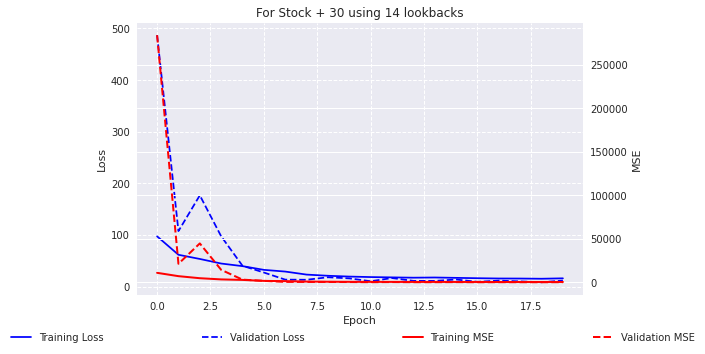

None
None
For ticker Close, the forecasted return is 1.278375%


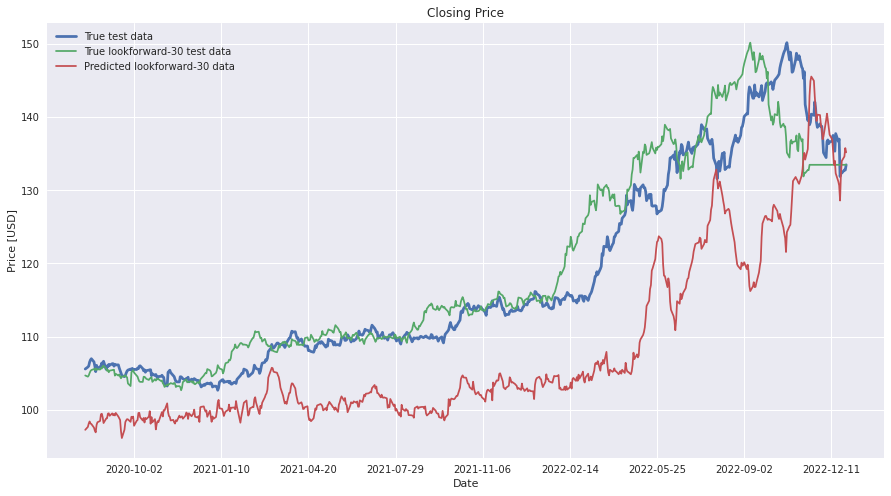

In [ ]:
target_variable ='Close'
train_size = 0.6
lookahead = 30

epoch_count = 20
batch_size = 20
lookbacks = 14

run_prediction(price_stock, target_variable, train_size, lookahead, lookbacks, epoch_count, batch_size)

Đây là một mô hình đơn giản. Nếu mọi người muốn phát triển mô hình thì mọi có thể thêm nhiều các chỉ báo làm đầu vào như mình liệt kê thêm ở phần hàm feature_engineering. Cảm ơn mọi người